# Hardbrücke 

## Quelle

https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke

In [ ]:
!pip install scikit-learn==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 63.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
import pickle

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics 
import sklearn
print(sklearn.__version__)


1.0.1


## Get Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

In [ ]:
os.listdir('/content/gdrive/MyDrive/ColabNotebooks/hardbruecke')

['frequenzen_hardbruecke_2020.zip',
 'models',
 'test_plots.ipynb',
 'plot_tree.ipynb',
 'frequenzen_hardbruecke_2021.zip',
 'frequenzen_hardbruecke_2022.zip',
 'hardbruecke.ipynb',
 'hardbruecke_retrain.ipynb']

In [ ]:
filepaths = [
             'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2020.csv',
             'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2021.csv',
             'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2022.csv',
]

In [ ]:
hb = pd.DataFrame()
print("shape df: ", hb.shape)
for file in filepaths:
  print(file)
  hb = hb.append(pd.read_csv(file))
  print("shape df: ", hb.shape)

shape df:  (0, 0)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2020.csv
shape df:  (714681, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2021.csv
shape df:  (1440537, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2022.csv
shape df:  (2184165, 4)


In [ ]:
hb

,In,Out,Timestamp,Name
0,1,0,2020-01-01T23:55:00,Ost-Nord total
1,2,5,2020-01-01T23:50:00,Ost-Nord total
2,1,0,2020-01-01T23:45:00,Ost-Nord total
3,1,4,2020-01-01T23:40:00,Ost-Nord total
4,1,0,2020-01-01T23:35:00,Ost-Nord total
...,...,...,...,...
743623,16,11,2022-12-31T23:55:00,Ost-SBB total
743624,1,18,2022-12-31T23:55:00,Ost-Süd total
743625,12,0,2022-12-31T23:55:00,West-Nord total
743626,14,7,2022-12-31T23:55:00,West-SBB total


In [ ]:
def add_previous_count(df):
  df = df.sort_values(['name_cat','direction_cat','Timestamp'])
  df['count_previous'] = df['count'].shift(1, fill_value= 0)
  # set first values to 
  df.loc[df['Timestamp']=='2020-01-01 00:00:00','count_previous'] = 0
  return df
#test = add_previous_count(hb2)

In [ ]:
# data from: https://github.com/alexanderguentert/predict_hardbruecke/blob/main/streamlit_app.py

names = {
    'Ost-Süd total': 0,
    'Ost-Sd total': 0,  # alias, as seen in api query (2020 and 2021)
    'Ost-Nord total': 1,
    'Ost-SBB total': 2,
    'West-SBB total': 3,
    'West-Süd total': 4,
    'West-Sd total': 4,  # alias, as seen in api query (2020 and 2021)
    'Ost-VBZ Total': 5,
    'West-Nord total': 6,
    'West-VBZ total': 7,
}

def data_preparation(df, names): #, date):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # df = df.merge(pd.DataFrame({'Timestamp': create_date_range(date)}), how='right')
    # df[['In', 'Out']] = df[['In', 'Out']].fillna(9999)  # fill with dummy value

    df = df.set_index(['Timestamp', 'Name']).stack().reset_index()
    df = df.rename(columns={'level_2': 'direction', 0: 'count'})

    df.loc[df['Name'].isna(), 'count'] = np.nan  # remove dummy value

    df['direction'] = df['direction'].astype('category')
    df['year'] = df['Timestamp'].dt.year
    df['hour'] = df['Timestamp'].dt.hour
    df['weekday'] = df['Timestamp'].dt.weekday
    df['minute'] = df['Timestamp'].dt.minute
    df['month'] = df['Timestamp'].dt.month
    df['day'] = pd.to_datetime(df['Timestamp'].dt.date)
    df['direction_cat'] = df['direction'].replace({'In': 0, 'Out': 1})
    df['name_cat'] = df['Name'].replace(names)

    #df = add_previous_count(df)

    return df

In [ ]:
hb2 = data_preparation(hb, names)

In [ ]:
hb2

,Timestamp,Name,direction,count,year,hour,weekday,minute,month,day,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1.0,2020,23,2,55,1,2020-01-01,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0.0,2020,23,2,55,1,2020-01-01,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2.0,2020,23,2,50,1,2020-01-01,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5.0,2020,23,2,50,1,2020-01-01,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1.0,2020,23,2,45,1,2020-01-01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4368325,2022-12-31 23:55:00,West-Nord total,Out,0.0,2022,23,5,55,12,2022-12-31,1,6
4368326,2022-12-31 23:55:00,West-SBB total,In,14.0,2022,23,5,55,12,2022-12-31,0,3
4368327,2022-12-31 23:55:00,West-SBB total,Out,7.0,2022,23,5,55,12,2022-12-31,1,3
4368328,2022-12-31 23:55:00,West-Süd total,In,1.0,2022,23,5,55,12,2022-12-31,0,4


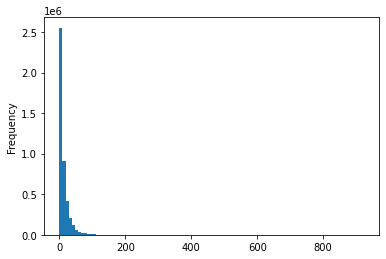

In [ ]:
hb2['count'].plot(kind='hist', bins=100)

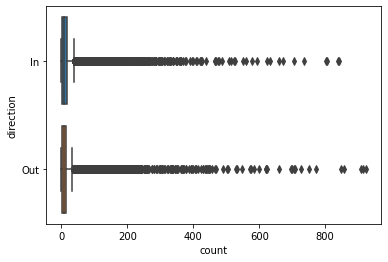

In [ ]:
sns.boxplot(data=hb2,x='count',y='direction')

In [ ]:
hb2['Name'].value_counts()

Ost-Süd total      573078
Ost-Nord total     561918
Ost-SBB total      560034
West-SBB total     552476
West-Süd total     544448
Ost-VBZ Total      534324
West-Nord total    526852
West-VBZ total     515200
Name: Name, dtype: int64

In [ ]:
hb2['direction'].value_counts()

In     2184165
Out    2184165
Name: direction, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

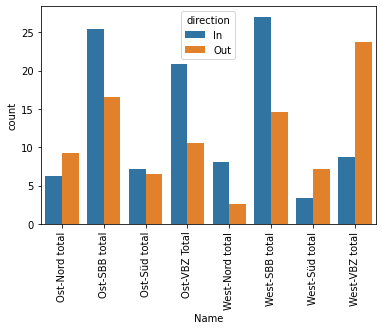

In [ ]:
name = hb2.groupby(['Name','direction'])['count'].mean()
sns.barplot(data=name.reset_index(),x='Name',y='count',hue='direction')
plt.xticks(rotation = 90)

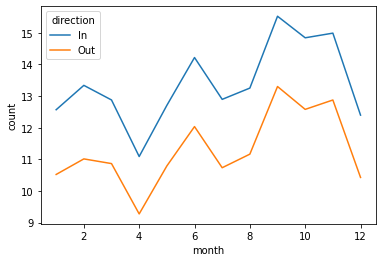

In [ ]:
months = hb2.groupby(['month','direction'])['count'].mean()
sns.lineplot(data=months.reset_index(),x='month',y='count',hue='direction')

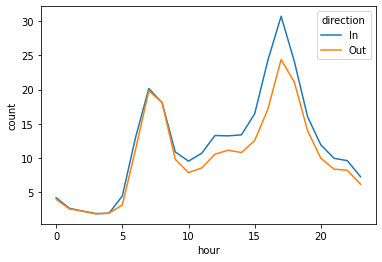

In [ ]:
hour = hb2.groupby(['hour','direction'])['count'].mean()
sns.lineplot(data=hour.reset_index(),x='hour',y='count',hue='direction')

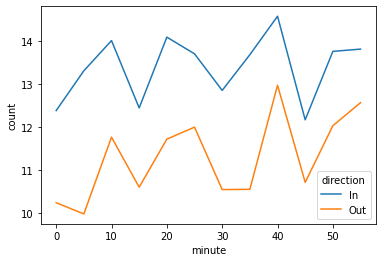

In [ ]:
minute = hb2.groupby(['minute','direction'])['count'].mean()
sns.lineplot(data=minute.reset_index(),x='minute',y='count',hue='direction')

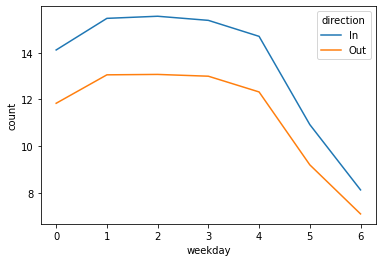

In [ ]:
weekday = hb2.groupby(['weekday','direction'])['count'].mean()
sns.lineplot(data=weekday.reset_index(),x='weekday',y='count',hue='direction')

# Machine Learning

In [ ]:
XList=[
  'year',
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
  #'count_previous',
  #'holiday',
]
y='count'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

In [ ]:
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
  regressor = model
  regressor.fit(X_train, y_train)  
  y_pred = regressor.predict(X_test) 
  metric_df = pd.DataFrame(
    index=['Mean Absolute Error','Mean Squared Error','Root Mean Squared Error'],
    data={'value':[metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred))]})
  return {
      'model': regressor,
      'y_pred': y_pred,
      'metrics': metric_df
  }

In [59]:
if True:
    reg = fit_and_evaluate(RandomForestRegressor(n_estimators=7,n_jobs=-1,
                                                max_depth=20,
                                                min_samples_split=10,
                                                min_samples_leaf=10,
                                                ),
                          X_train, X_test, y_train, y_test)
    print(reg['metrics'])

                             value
Mean Absolute Error       4.462070
Mean Squared Error       65.930697
Root Mean Squared Error   8.119772


In [60]:
filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/2023-01-02_RandomForestRegressor.sav'
pickle.dump(reg['model'], open(filename, 'wb'))

In [ ]:
models = {
          'DecisionTree': DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5), 
          'RandomForest': RandomForestRegressor(n_estimators=10,n_jobs=-1,max_depth=20, min_samples_leaf=10) ,
          'GradientBoosting': GradientBoostingRegressor(n_estimators=10, min_samples_leaf=10, max_depth=20),
          'LinearRegression': LinearRegression(),
          # 'CatBoost': CatBoostRegressor(n_estimators=10,loss_function = 'RMSE', eval_metric = 'RMSE',cat_features = ['name_cat'])
          #'Support Vector Regression': SVR(kernel = 'rbf'), # vorsicht langsam

}

In [ ]:
output = {}
for m in models:
  print('\n'+m)
  output[m] = fit_and_evaluate(models[m], X_train, X_test, y_train, y_test)
  print(output[m]['metrics'])



DecisionTree
                             value
Mean Absolute Error       4.757112
Mean Squared Error       75.018138
Root Mean Squared Error   8.661301

RandomForest
                             value
Mean Absolute Error       4.453775
Mean Squared Error       65.580944
Root Mean Squared Error   8.098206

GradientBoosting
                             value
Mean Absolute Error       5.616730
Mean Squared Error       86.642866
Root Mean Squared Error   9.308215

LinearRegression
                              value
Mean Absolute Error        9.862659
Mean Squared Error       234.617658
Root Mean Squared Error   15.317234


Random Forest schneidet am besten ab, produziert aber ein riesiges Modell. Decision Tree ist nicht viel schlechter, aber einiges kleiner. Gradient Boosting scheint sich nicht zu lohnen (gilt auch für LightGBM)

Text(0.5, 1.0, 'DecisionTree')

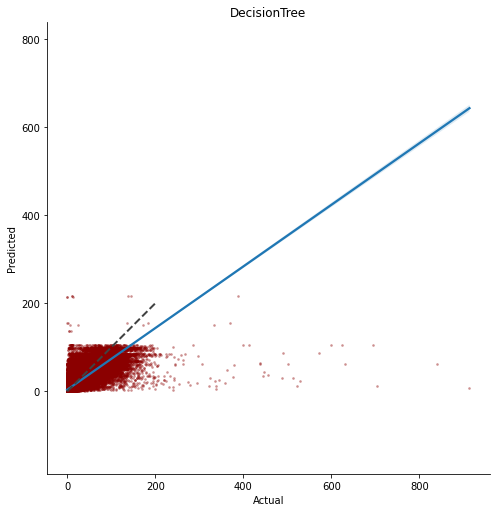

In [ ]:
model_name = 'DecisionTree'
df=pd.DataFrame({'Actual':y_test, 'Predicted':output[model_name]['y_pred']}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7).set(title=model_name)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
plt.title(model_name)

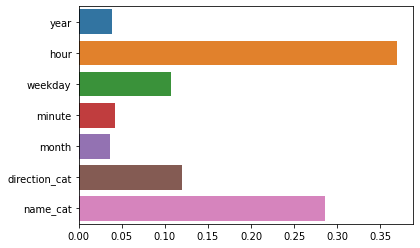

In [ ]:
sns.barplot(x=output[model_name]['model'].feature_importances_, 
            y=XList)

Text(0.5, 1.0, 'RandomForest')

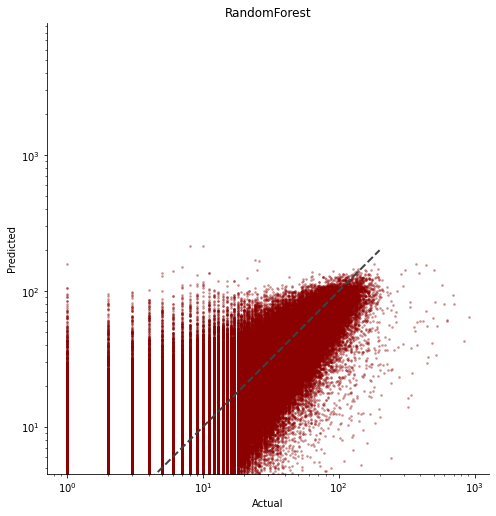

In [ ]:
model_name = 'RandomForest'
df=pd.DataFrame({'Actual':y_test, 'Predicted':output[model_name]['y_pred']}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
plt.title(model_name)

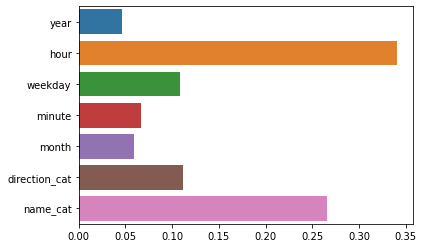

In [ ]:
sns.barplot(x=output[model_name]['model'].feature_importances_, 
            y=XList)

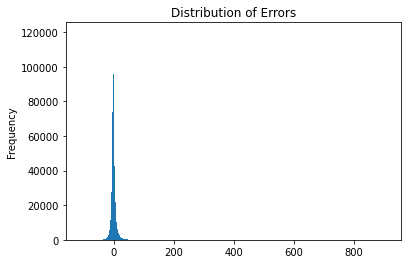

In [ ]:
(df['Actual']-df['Predicted']).plot(kind='hist', bins=1000, title='Distribution of Errors')

## Testplot

In [ ]:
## functions from app


def data_preparation(df, names, date):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    df = df.merge(pd.DataFrame({'Timestamp': create_date_range(date)}), how='right')
    df[['In', 'Out']] = df[['In', 'Out']].fillna(9999)  # fill with dummy value

    df = df.set_index(['Timestamp', 'Name']).stack().reset_index()
    df = df.rename(columns={'level_2': 'direction', 0: 'count'})

    df.loc[df['Name'].isna(), 'count'] = np.nan  # remove dummy value

    df['direction'] = df['direction'].astype('category')
    df['year'] = df['Timestamp'].dt.year
    df['hour'] = df['Timestamp'].dt.hour
    df['weekday'] = df['Timestamp'].dt.weekday
    df['minute'] = df['Timestamp'].dt.minute
    df['month'] = df['Timestamp'].dt.month
    df['day'] = pd.to_datetime(df['Timestamp'].dt.date)
    df['direction_cat'] = df['direction'].replace({'In': 0, 'Out': 1})
    df['name_cat'] = df['Name'].replace(names)

    #df = add_previous_count(df)

    return df


def plot_day(df, day, name, regressor, XList):
    df['name_cat'] = df['name_cat'].fillna(names[name])
    df['Name'] = df['Name'].fillna(name)
    df_filter = df[(df['day'] == day) & (df['Name'] == name)].copy()
    df_filter['prediction'] = regressor.predict(df_filter[XList])
    melted = df_filter.melt(id_vars=['Timestamp', 'direction', 'Name'], value_vars=['count', 'prediction'])
    melted['value'] = melted['value'].astype(float)
    fig = px.line(melted, x='Timestamp', y='value', color='variable', facet_row='direction', title=name)
    return fig


def create_date_range(date, freq='5min'):
    return pd.date_range('{} 00:00:00'.format(date), '{} 23:55:00'.format(date), freq=freq)


def create_future_df(name, date):
    future = pd.DataFrame({'Timestamp': create_date_range(date), })
    future['In'] = 0
    future['Out'] = 0
    future['Name'] = name
    return future


def download_from_api(date, resource):
    url_day = """https://data.stadt-zuerich.ch/api/3/action/datastore_search_sql?""" \
        """sql=SELECT%20%22Timestamp%22,%22Name%22,%22In%22,%22Out%22%20""" \
        """from%20%22{resource}%22""" \
        """where%20%22Timestamp%22::TIMESTAMP::DATE=%27{day}%27%20;"""
    df = pd.read_json(url_day.format(day=date, resource=resource)).loc['records', 'result']
    df = pd.DataFrame.from_dict(df)
    if df.empty:
        data_available = False
    else:
        data_available = True
    return data_available, df


def get_from_api(url):
    """
    Download from api. For historical data
    :param url:
    :return:
    """
    df = pd.read_json(url).loc['records', 'result']
    df = pd.DataFrame.from_dict(df)
    if df.empty:
        data_available = False
    else:
        data_available = True
    return data_available, df

def update_plots_tab1(date, location_name):
    year = date[0:4]
    if year in resource_api:
        resource_year = resource_api[year]
        # data from api
        data_available, df_api = download_from_api(date, resource_year)
        if data_available:
            plot_df = data_preparation(df_api, names, date)
        else:
            future = data_preparation(create_future_df(location_name, date), names, date)
            future['count'] = np.nan  # no real data available
            plot_df = future
    else:
        future = data_preparation(create_future_df(location_name, date), names, date)
        future['count'] = np.nan  # no real data available
        plot_df = future
    return plot_day(plot_df, date, location_name, regressor, XList)

resource_api = {
    '2022': """a0c89c3e-72e7-4cbe-965a-efa16b3ecd5f""",
    '2021': """2f27e464-4910-46bf-817b-a9bac19f86f3""",
    '2020': """5baeaf58-9af2-4a39-a357-9063ca450893""",
}

In [ ]:
model_name = 'RandomForest' #'GradientBoosting' #'RandomForest'
regressor =   reg['model'] #output[model_name]['model'] #gbm
update_plots_tab1('2022-12-01', 'Ost-VBZ Total')

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
if False:
    scores = cross_val_score(DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5),
                            hb2[XList], hb2[y], cv=5,scoring = 'neg_mean_absolute_error')
    print(scores)
    print("neg_mean_absolute_error %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Production Model

In [ ]:
if False:
    regressor = DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5)
    regressor.fit(hb2[XList], hb2[y])

In [ ]:

filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/2022-01-05_DecisionTreeRegressor.sav'
#pickle.dump(regressor, open(filename, 'wb'))

## lgbm

In [ ]:
import lightgbm as lgb

In [ ]:
categorical_features = ['direction_cat','name_cat','weekday']

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train
 ,feature_name = XList
 , categorical_feature = categorical_features
)

In [ ]:
params = {
 'task': 'train' 
 #, 'boosting_type': 'dart'
 #, 'max_depth' : 25
 , 'objective': 'regression' 
 #, 'num_leaves':60
 #, 'num_class': num_of_classes
 , 'metric': 'mse' #'mae' #'rmsle' 
 #,'min_data_in_leaf': 40
 #,'num_trees':100 # default 100
 #, 'min_data': 5
 #, 'verbose': -1
}
gbm = lgb.train(params, lgb_train)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.



In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred) )
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('R2 Score: ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 5.012408735532897
Mean Squared Error: 78.0878296307074
Root Mean Squared Error: 8.836731841054554


Text(0.5, 1.0, 'LightGBM')

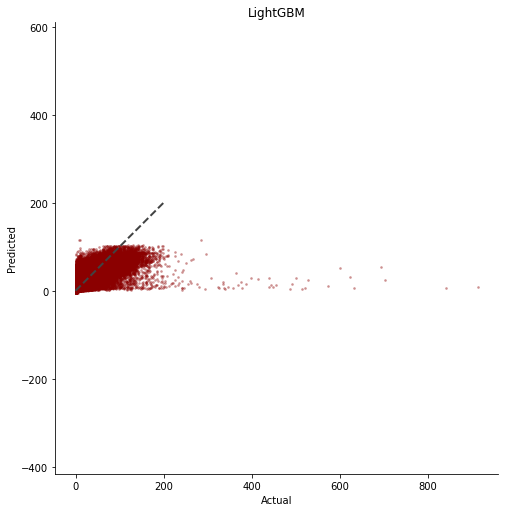

In [ ]:
model_name = 'LightGBM'
df=pd.DataFrame({'Actual':y_test, 'Predicted':gbm.predict(X_test)}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
#plt.xscale('log')
#plt.yscale('log')
plt.title(model_name)